In [1]:
pip install timm

Note: you may need to restart the kernel to use updated packages.


In [2]:
import numpy as np
import pandas as pd

import os

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cv2
from PIL import Image
from multiprocessing import Pool
from tqdm import tqdm

from sklearn.model_selection import train_test_split
from torchvision import transforms, models
import torch
from torch import nn, optim
from torch.utils.data import DataLoader, Dataset
from sklearn.metrics import cohen_kappa_score
import timm
import copy

In [3]:
## for removing file if required
import shutil

try:
    shutil.rmtree("/kaggle/working/train")
    
    model_file_to_delete ="/kaggle/working/models"

    if os.path.isfile(model_file_to_delete):
        os.remove(model_file_to_delete)
    
except:
    print("No such directories")

No such directories


EDA

In [4]:
def load_data(data_dir):
    train_csv = os.path.join(data_dir, 'train.csv')
    test_csv = os.path.join(data_dir, 'test.csv')
    
    train = pd.read_csv(train_csv)
    test = pd.read_csv(test_csv)
    
    train_dir = os.path.join(data_dir, 'train_images/')
    test_dir = os.path.join(data_dir, 'test_images/')
    
    train['file_path'] = train['id_code'].map(lambda x: os.path.join(train_dir, '{}.png'.format(x)))
    test['file_path'] = test['id_code'].map(lambda x: os.path.join(test_dir, '{}.png'.format(x)))
    
    train['file_name'] = train["id_code"] + ".png"
    test['file_name'] = test["id_code"] + ".png"
    
    train['diagnosis'] = train['diagnosis'].astype(str)
    
    return train, test

In [5]:
data_dir = '/kaggle/input/aptos2019-blindness-detection/'
train_df, test_df = load_data(data_dir)

In [6]:
print(train_df.shape)
train_df.head()

(3662, 4)


,id_code,diagnosis,file_path,file_name
0,000c1434d8d7,2,/kaggle/input/aptos2019-blindness-detection/tr...,000c1434d8d7.png
1,001639a390f0,4,/kaggle/input/aptos2019-blindness-detection/tr...,001639a390f0.png
2,0024cdab0c1e,1,/kaggle/input/aptos2019-blindness-detection/tr...,0024cdab0c1e.png
3,002c21358ce6,0,/kaggle/input/aptos2019-blindness-detection/tr...,002c21358ce6.png
4,005b95c28852,0,/kaggle/input/aptos2019-blindness-detection/tr...,005b95c28852.png


In [7]:
print(test_df.shape)
test_df.head()

(1928, 3)


,id_code,file_path,file_name
0,0005cfc8afb6,/kaggle/input/aptos2019-blindness-detection/te...,0005cfc8afb6.png
1,003f0afdcd15,/kaggle/input/aptos2019-blindness-detection/te...,003f0afdcd15.png
2,006efc72b638,/kaggle/input/aptos2019-blindness-detection/te...,006efc72b638.png
3,00836aaacf06,/kaggle/input/aptos2019-blindness-detection/te...,00836aaacf06.png
4,009245722fa4,/kaggle/input/aptos2019-blindness-detection/te...,009245722fa4.png


In [8]:
def plot_dis_classes(df):
    df_group = df['diagnosis'].value_counts().reset_index()
    df_group.columns = ['diagnosis', 'count']

    plt.figure(figsize=(10, 5))
    plt.bar(df_group['diagnosis'], df_group['count'], color='skyblue')
    plt.xlabel('Diagnosis')
    plt.ylabel('Count')
    plt.title('Output Class Distribution')
    plt.show()

diagnosis
0    1805
2     999
1     370
4     295
3     193
Name: count, dtype: int64


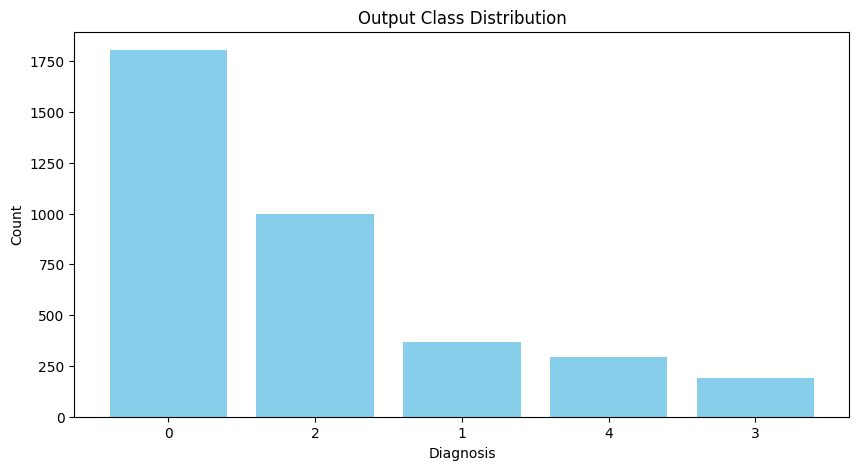

In [9]:
print(train_df['diagnosis'].value_counts())
plot_dis_classes(train_df)

In [10]:
def visualize_imgs(df, plots_per_class, color_scale, img_size):
    df = df.groupby('diagnosis',group_keys = False).apply(lambda df: df.sample(plots_per_class)).reset_index(drop=True)
    
    plt.rcParams["axes.grid"] = False
    for pt in range(plots_per_class):
        f, axarr = plt.subplots(1,5,figsize = (15,15))
        axarr[0].set_ylabel("Sample Data Points")
        
        df_temp = df[df.index.isin([pt + (plots_per_class*0),pt + (plots_per_class*1), pt + (plots_per_class*2),pt + (plots_per_class*3),pt + (plots_per_class*4)])]
        for i in range(5):
            if color_scale == 'gray':
                img = convert_to_gray(cv2.imread(df_temp.file_path.iloc[i]), img_size)
                axarr[i].imshow(img,cmap = color_scale)
            else: ## RGB
                axarr[i].imshow(Image.open(df_temp.file_path.iloc[i]).resize((img_size,img_size)))
            axarr[i].set_xlabel('Class '+str(df_temp.diagnosis.iloc[i]))

        plt.show()

/tmp/ipykernel_34/136394828.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.groupby('diagnosis',group_keys = False).apply(lambda df: df.sample(plots_per_class)).reset_index(drop=True)


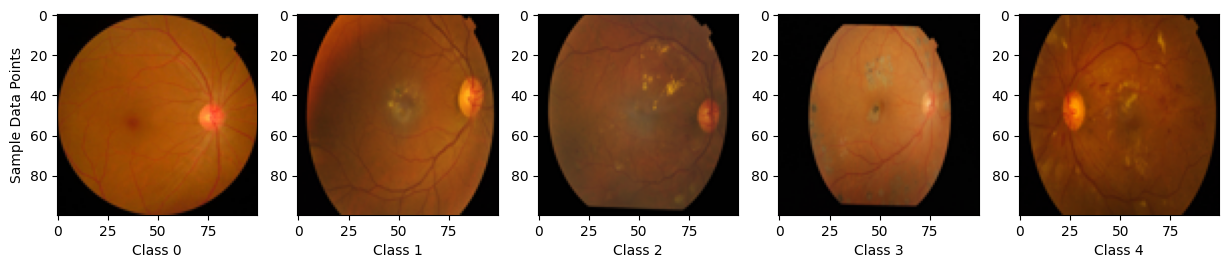

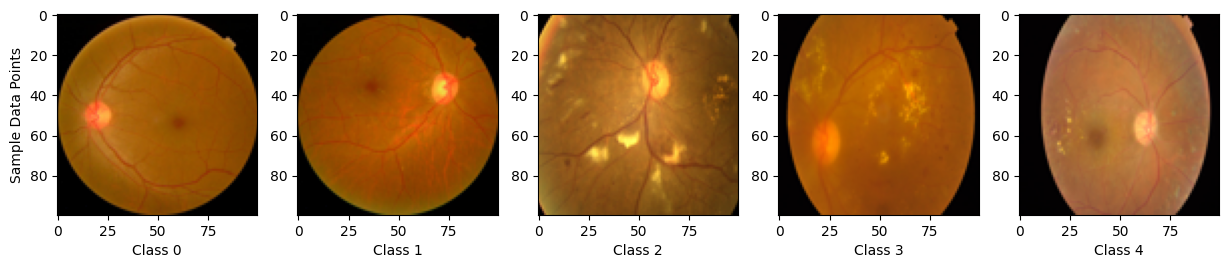

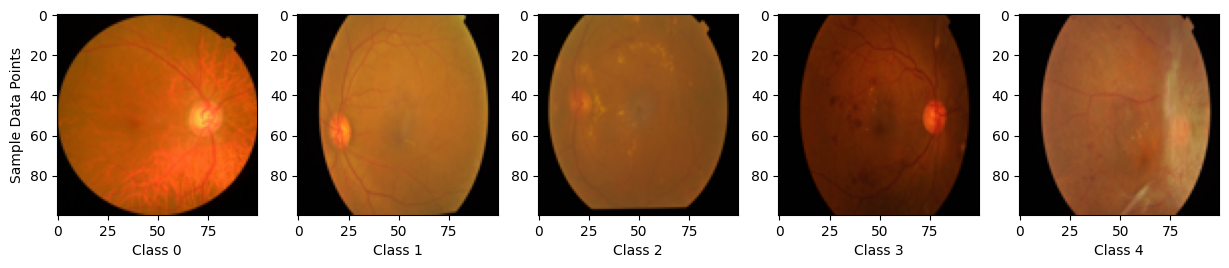

In [11]:
plots_per_class = 3
img_size = 100
visualize_imgs(train_df,plots_per_class,None, img_size)

pre-processing

In [12]:
def crop_img(img, percentage):
    
    img_arr = np.array(img)
    img_gray = cv2.cvtColor(img_arr, cv2.COLOR_BGR2GRAY)
    
    threshold = img_gray > 0.1 * np.mean(img_gray[img_gray != 0])
    row_sums = np.sum(threshold, axis=1)
    col_sums = np.sum(threshold, axis=0)
    
    rows = np.where(row_sums > img_arr.shape[1] * percentage)[0]
    cols = np.where(col_sums > img_arr.shape[0] * percentage)[0]
    
    min_row, min_col = np.min(rows), np.min(cols)
    max_row, max_col = np.max(rows), np.max(cols)
    
    crop_img = img_arr[min_row : max_row + 1, min_col : max_col + 1]
    
    return Image.fromarray(crop_img)


In [13]:
def resize_maintain_aspect(img, desired_size):
    old_width, old_height = img.size
    aspect_ratio = old_width / old_height

    if aspect_ratio > 1:
        new_width = desired_size
        new_height = int(desired_size / aspect_ratio)
    else:
        new_height = desired_size
        new_width = int(desired_size * aspect_ratio)

    resized_img = img.resize((new_width, new_height), Image.ANTIALIAS)
    
    padded_image = Image.new("RGB", (desired_size, desired_size))
    x_offset = (desired_size - new_width) // 2
    y_offset = (desired_size - new_height) // 2
    padded_image.paste(resized_img, (x_offset, y_offset))
    
    return padded_image

In [14]:
def save_single(args):
    image_path, output_path_folder, percentage, output_size = args
    image = Image.open(image_path)
    
    # Display the image
    #plt.imshow(image)
    #plt.title('Original Image')
    #plt.show()
    
    croped_img = crop_img(image,percentage)
    image_resized = resize_maintain_aspect(croped_img, desired_size=output_size[0])
    
    #print(output_path_folder)
    #print(image_path)
    output_image_path = os.path.basename(image_path)
    # Save the resized image
    output_file_path = os.path.join(output_path_folder, output_image_path)
    #print(output_file_path)
    image_resized.save(output_file_path)

In [15]:
def fast_image_resize(df, output_path_folder, percentage, output_size=None):
    """Uses multiprocessing to make it fast"""
    if not output_size:
        warnings.warn("Need to specify output_size! For example: output_size=100")
        return

    if not os.path.exists(output_path_folder):
        os.makedirs(output_path_folder)
        
    jobs = []
    for df_item in range(len(df)):
        image_path = df.file_path.iloc[df_item]
        #print(image_path)
        job = (image_path, output_path_folder, percentage, output_size)
        jobs.append(job)
    
    """
    results = []
    for job in tqdm(jobs, total=len(jobs)):
        result = save_single(job)
        results.append(result)
    """
    with Pool() as p:
        list(tqdm(p.imap_unordered(save_single, jobs), total=len(jobs)))

In [16]:
percentage = 0.01
fast_image_resize(train_df, "/kaggle/working/train/images_resized_150/",percentage, output_size=(150, 150))

  0%|          | 0/3662 [00:00<?, ?it/s]/tmp/ipykernel_34/3153832717.py:12: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  resized_img = img.resize((new_width, new_height), Image.ANTIALIAS)
  0%|          | 1/3662 [00:00<12:46,  4.77it/s]/tmp/ipykernel_34/3153832717.py:12: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  resized_img = img.resize((new_width, new_height), Image.ANTIALIAS)
  0%|          | 2/3662 [00:00<15:37,  3.90it/s]/tmp/ipykernel_34/3153832717.py:12: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  resized_img = img.resize((new_width, new_height), Image.ANTIALIAS)
/tmp/ipykernel_34/3153832717.py:12: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resam

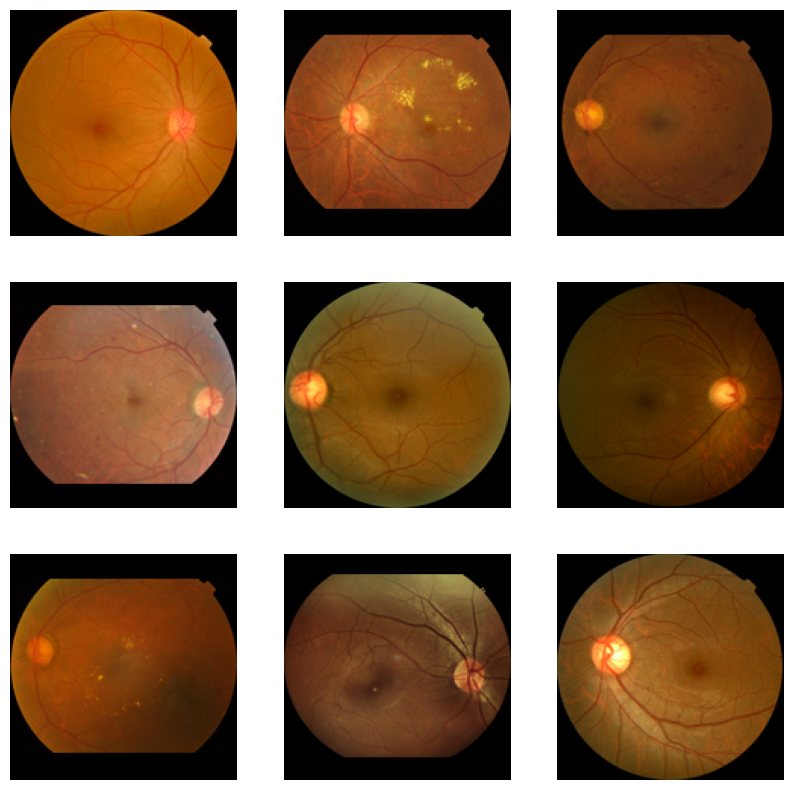

In [17]:
# Path to the directory containing the images
directory = "/kaggle/working/train/images_resized_150"

# Get a list of image filenames in the directory
image_files = os.listdir(directory)

# Define the number of images to display
num_images_to_display = 9

# Display the first few images
fig, axes = plt.subplots(3, 3, figsize=(10, 10))

for i, ax in enumerate(axes.flat):
    # Check if there are more images to display
    if i < len(image_files):
        # Load the image
        img_path = os.path.join(directory, image_files[i])
        img = mpimg.imread(img_path)
        
        # Display the image
        ax.imshow(img)
        ax.axis('off')  # Hide axis
    else:
        # If there are no more images, remove the axis
        ax.axis('off')

plt.show()

Model_Implementation

In [18]:
class BlindnessDataset(Dataset):
    def __init__(self, csv_file, root_dir, transform=None, test=False):
        self.annotations = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform
        self.test = test
    
    def __len__(self):
        return len(self.annotations)
    
    def __getitem__(self, idx):
        img_name = os.path.join(self.root_dir, self.annotations.iloc[idx, 0] + '.png')
        image = Image.open(img_name)
        
        if self.transform:
            image = self.transform(image)
        
        if self.test:
            return image
        else:
            label = int(self.annotations.iloc[idx, 1])
            return image, label

In [30]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
]) ## for the model

In [20]:
csv_file = '/kaggle/input/aptos2019-blindness-detection/train.csv'
pros_img_dir = '/kaggle/working/train/images_resized_150'

In [31]:
dataset = BlindnessDataset(csv_file, pros_img_dir, transform=transform)
train_indices, val_indices = train_test_split(list(range(len(dataset))), test_size=0.2, stratify=dataset.annotations.iloc[:, 1])
train_sampler = torch.utils.data.SubsetRandomSampler(train_indices)
val_sampler = torch.utils.data.SubsetRandomSampler(val_indices)

train_loader = DataLoader(dataset, batch_size=32, sampler=train_sampler)
val_loader = DataLoader(dataset, batch_size=32, sampler=val_sampler)

In [22]:
def quadratic_weighted_kappa(y_true, y_pred):
    return cohen_kappa_score(y_true, y_pred, weights='quadratic')

In [23]:
models_path = "/kaggle/working/models"
if not os.path.exists(models_path):
        os.makedirs(models_path)

In [24]:
def train_model(model_name,model,num_of_epochs,criterion,optimizer,scheduler, best_model_wts, best_kappa, patience, counter):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    torch.cuda.empty_cache()
    model.to(device)
    for epoch in range(num_of_epochs): 
        model.train()
        running_loss = 0.0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        print(f"Epoch {epoch+1}, Loss: {running_loss/len(train_loader)}")

        # validation
        model.eval()
        val_preds = []
        val_labels = []
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                _, predicted = torch.max(outputs.data, 1)
                val_preds.extend(predicted.cpu().numpy())
                val_labels.extend(labels.cpu().numpy())

        kappa = quadratic_weighted_kappa(val_labels, val_preds)
        print(f"Validation Keppa: {kappa}")

        if kappa > best_kappa:
            best_kappa = kappa
            best_model_wts = copy.deepcopy(model.state_dict())
            counter = 0
        else:
            counter += 1
            if counter >= patience:
                print("Early stopping triggered")
                break

        scheduler.step()
        
    # Best Model
    print(f"Best Validation QWK: {best_kappa}")
    model.load_state_dict(best_model_wts)
    torch.save(model.state_dict(), f'/kaggle/working/models/{model_name}.pth')

ResNet18


In [25]:
model = models.resnet18(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 5)

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 157MB/s] 


In [26]:
model_name = "resnet18"
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001,weight_decay=1e-3)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)
num_of_epochs = 13
##Parameters to avoid overfitting
best_model_wts = copy.deepcopy(model.state_dict())
best_kappa = 0.0
patience = 3
counter = 0

In [27]:
train_model(model_name,model,num_of_epochs,criterion,optimizer,scheduler, best_model_wts, best_kappa, patience, counter)

Epoch 1, Loss: 0.7428576943019162
Validation Keppa: 0.7664564980920543
Epoch 2, Loss: 0.5936040285488834
Validation Keppa: 0.773366518850893
Epoch 3, Loss: 0.588563406597013
Validation Keppa: 0.37764782845236644
Epoch 4, Loss: 0.527739650691333
Validation Keppa: 0.75723429328445
Epoch 5, Loss: 0.5127557713700377
Validation Keppa: 0.8103389812485748
Epoch 6, Loss: 0.41936835322691046
Validation Keppa: 0.865924269379596
Epoch 7, Loss: 0.3432234290825284
Validation Keppa: 0.8707326960940869
Epoch 8, Loss: 0.2830262628748365
Validation Keppa: 0.8767393581886237
Epoch 9, Loss: 0.23347049562827402
Validation Keppa: 0.8736226431696061
Epoch 10, Loss: 0.2025775766890982
Validation Keppa: 0.8793183520113018
Epoch 11, Loss: 0.14528079573874889
Validation Keppa: 0.8672138038502059
Epoch 12, Loss: 0.12085149890702704
Validation Keppa: 0.8788463941755322
Epoch 13, Loss: 0.10959242747934617
Validation Keppa: 0.8796500053589223
Best Validation QWK: 0.8796500053589223


EfficientNet b0

In [34]:
model = timm.create_model('efficientnet_b0', pretrained=True, num_classes=5)
model_name = "efficentNet_b0"
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001,weight_decay=1e-3)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)
num_of_epochs = 13

model.safetensors:   0%|          | 0.00/21.4M [00:00<?, ?B/s]

In [35]:
##Parameters to avoid overfitting
best_model_wts = copy.deepcopy(model.state_dict())
best_kappa = 0.0
patience = 3
counter = 0

In [36]:
train_model(model_name,model,num_of_epochs,criterion,optimizer,scheduler, best_model_wts, best_kappa, patience, counter)

Epoch 1, Loss: 0.914130432450253
Validation Keppa: 0.838258901333738
Epoch 2, Loss: 0.4893802859536979
Validation Keppa: 0.86656794107952
Epoch 3, Loss: 0.40654524051300855
Validation Keppa: 0.8349649932319344
Epoch 4, Loss: 0.3755956667110972
Validation Keppa: 0.8811834373094222
Epoch 5, Loss: 0.36243476844190253
Validation Keppa: 0.8487688973441637
Epoch 6, Loss: 0.18068886949154345
Validation Keppa: 0.8922948733004091
Epoch 7, Loss: 0.09776519291588794
Validation Keppa: 0.8833581027631654
Epoch 8, Loss: 0.06361395360790598
Validation Keppa: 0.8848573795769165
Epoch 9, Loss: 0.057532846664442965
Validation Keppa: 0.883574490222285
Early stopping triggered
Best Validation QWK: 0.8922948733004091


EfficientNet b1

In [28]:
model = timm.create_model('efficientnet_b1', pretrained=True, num_classes=5)
model_name = "efficentNet_b1"
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001,weight_decay=1e-3)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)
num_of_epochs = 13

model.safetensors:   0%|          | 0.00/31.5M [00:00<?, ?B/s]

In [29]:
##Parameters to avoid overfitting
best_model_wts = copy.deepcopy(model.state_dict())
best_kappa = 0.0
patience = 3
counter = 0

In [30]:
train_model(model_name,model,num_of_epochs,criterion,optimizer,scheduler, best_model_wts, best_kappa, patience, counter)

Epoch 1, Loss: 0.8833130034415618
Validation Keppa: 0.8470052087674806
Epoch 2, Loss: 0.4214321191868056
Validation Keppa: 0.8305439457818498
Epoch 3, Loss: 0.33338428515455
Validation Keppa: 0.8749277274819702
Epoch 4, Loss: 0.282858529239488
Validation Keppa: 0.8332408987807693
Epoch 5, Loss: 0.3336779632322166
Validation Keppa: 0.8480610768488779
Epoch 6, Loss: 0.11357117885642726
Validation Keppa: 0.8789678694735346
Epoch 7, Loss: 0.06338740053141247
Validation Keppa: 0.8846013304573178
Epoch 8, Loss: 0.04465398593785484
Validation Keppa: 0.8899683259098694
Epoch 9, Loss: 0.03968225830264956
Validation Keppa: 0.8896985200919083
Epoch 10, Loss: 0.03236586218143044
Validation Keppa: 0.8946405288170645
Epoch 11, Loss: 0.024712277444727395
Validation Keppa: 0.8896184587300656
Epoch 12, Loss: 0.02321076632411543
Validation Keppa: 0.891076509275425
Epoch 13, Loss: 0.024572696334317974
Validation Keppa: 0.8865227049100959
Early stopping triggered
Best Validation QWK: 0.8946405288170645


EfficientNet b2

In [31]:
model = timm.create_model('efficientnet_b2', pretrained=True, num_classes=5)
model_name = "efficentNet_b2"
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001,weight_decay=1e-3)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)
num_of_epochs = 13

model.safetensors:   0%|          | 0.00/36.8M [00:00<?, ?B/s]

In [32]:
##Parameters to avoid overfitting
best_model_wts = copy.deepcopy(model.state_dict())
best_kappa = 0.0
patience = 3
counter = 0

In [33]:
train_model(model_name,model,num_of_epochs,criterion,optimizer,scheduler, best_model_wts, best_kappa, patience, counter)

Epoch 1, Loss: 1.0105072217790976
Validation Keppa: 0.8553489133981764
Epoch 2, Loss: 0.45449402134703554
Validation Keppa: 0.8618546767564437
Epoch 3, Loss: 0.3674444390622818
Validation Keppa: 0.8779986349430627
Epoch 4, Loss: 0.30512383717881597
Validation Keppa: 0.860695229055615
Epoch 5, Loss: 0.2643636295814877
Validation Keppa: 0.8661507859315303
Epoch 6, Loss: 0.13220490019201583
Validation Keppa: 0.8873779759708388
Epoch 7, Loss: 0.056038739858195186
Validation Keppa: 0.8897848519769002
Epoch 8, Loss: 0.04323270251852986
Validation Keppa: 0.8908807823727934
Epoch 9, Loss: 0.03411619807466986
Validation Keppa: 0.8984938778650349
Epoch 10, Loss: 0.033659855717459046
Validation Keppa: 0.889191103687027
Epoch 11, Loss: 0.02601029100617819
Validation Keppa: 0.8930375388618496
Epoch 12, Loss: 0.02208940490305869
Validation Keppa: 0.8888960141780299
Early stopping triggered
Best Validation QWK: 0.8984938778650349


EfficientNet b3

In [37]:
model = timm.create_model('efficientnet_b3', pretrained=True, num_classes=5)
model_name = "efficentNet_b3"
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001,weight_decay=1e-3)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)
num_of_epochs = 13

model.safetensors:   0%|          | 0.00/49.3M [00:00<?, ?B/s]

In [38]:
##Parameters to avoid overfitting
best_model_wts = copy.deepcopy(model.state_dict())
best_kappa = 0.0
patience = 3
counter = 0

In [39]:
train_model(model_name,model,num_of_epochs,criterion,optimizer,scheduler, best_model_wts, best_kappa, patience, counter)

Epoch 1, Loss: 0.8919274181775425
Validation Keppa: 0.8554947516158729
Epoch 2, Loss: 0.4097050638950389
Validation Keppa: 0.8635782842894553
Epoch 3, Loss: 0.2979357573406204
Validation Keppa: 0.8768341901773683
Epoch 4, Loss: 0.2442178990205993
Validation Keppa: 0.8710602785417322
Epoch 5, Loss: 0.23983859724324683
Validation Keppa: 0.8350893248679669
Epoch 6, Loss: 0.13962776928573198
Validation Keppa: 0.892815257860615
Epoch 7, Loss: 0.05291193682173996
Validation Keppa: 0.8974365078028794
Epoch 8, Loss: 0.041297690846714315
Validation Keppa: 0.8948076221999757
Epoch 9, Loss: 0.03520574824854165
Validation Keppa: 0.8909886298246598
Epoch 10, Loss: 0.030438485060585663
Validation Keppa: 0.8974657668703003
Epoch 11, Loss: 0.022354352957336232
Validation Keppa: 0.8829664043068889
Epoch 12, Loss: 0.024580216396513963
Validation Keppa: 0.8888116022274708
Epoch 13, Loss: 0.023362060989197547
Validation Keppa: 0.8845378628564464
Early stopping triggered
Best Validation QWK: 0.897465766870

EfficientNet b4

In [40]:
model = timm.create_model('efficientnet_b4', pretrained=True, num_classes=5)
model_name = "efficentNet_b4"
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001,weight_decay=1e-3)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)
num_of_epochs = 13

model.safetensors:   0%|          | 0.00/77.9M [00:00<?, ?B/s]

In [41]:
##Parameters to avoid overfitting
best_model_wts = copy.deepcopy(model.state_dict())
best_kappa = 0.0
patience = 3
counter = 0

In [42]:
train_model(model_name,model,num_of_epochs,criterion,optimizer,scheduler, best_model_wts, best_kappa, patience, counter)

Epoch 1, Loss: 0.7250956455650537
Validation Keppa: 0.8362698515171079
Epoch 2, Loss: 0.32943804205759714
Validation Keppa: 0.8391153798639654
Epoch 3, Loss: 0.269156890394895
Validation Keppa: 0.8533093108845069
Epoch 4, Loss: 0.27810228356848593
Validation Keppa: 0.8627847931786006
Epoch 5, Loss: 0.263853276938038
Validation Keppa: 0.8692772584285284
Epoch 6, Loss: 0.11321972223484646
Validation Keppa: 0.8839709714341377
Epoch 7, Loss: 0.043556420534909907
Validation Keppa: 0.8862818294101164
Epoch 8, Loss: 0.037966402928324657
Validation Keppa: 0.8933580126829054
Epoch 9, Loss: 0.031521284320067774
Validation Keppa: 0.8798498384876379
Epoch 10, Loss: 0.02858220714045709
Validation Keppa: 0.8849924773255524
Epoch 11, Loss: 0.022950166736415627
Validation Keppa: 0.8865013271674262
Early stopping triggered
Best Validation QWK: 0.8933580126829054


EfficientNet b5

In [43]:
model = timm.create_model('efficientnet_b5', pretrained=True, num_classes=5)
model_name = "efficentNet_b5"
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001,weight_decay=1e-3)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)
num_of_epochs = 13

model.safetensors:   0%|          | 0.00/122M [00:00<?, ?B/s]

In [44]:
##Parameters to avoid overfitting
best_model_wts = copy.deepcopy(model.state_dict())
best_kappa = 0.0
patience = 3
counter = 0

In [45]:
train_model(model_name,model,num_of_epochs,criterion,optimizer,scheduler, best_model_wts, best_kappa, patience, counter)

Epoch 1, Loss: 1.5018692534902822
Validation Keppa: 0.7630867225832372
Epoch 2, Loss: 0.7111686928116757
Validation Keppa: 0.7914388068341394
Epoch 3, Loss: 0.6064044878534649
Validation Keppa: 0.7857560841069087
Epoch 4, Loss: 0.5662326783589695
Validation Keppa: 0.8271411726873191
Epoch 5, Loss: 0.5178300595801809
Validation Keppa: 0.8004476044926317
Epoch 6, Loss: 0.39114215127799823
Validation Keppa: 0.8655741580297069
Epoch 7, Loss: 0.3129714934722237
Validation Keppa: 0.8688070501402017
Epoch 8, Loss: 0.27300687255742756
Validation Keppa: 0.8709169144072647
Epoch 9, Loss: 0.24436805810293424
Validation Keppa: 0.8610613266938735
Epoch 10, Loss: 0.20605100478734012
Validation Keppa: 0.857957192050812
Epoch 11, Loss: 0.13655449601862094
Validation Keppa: 0.8682638748273173
Early stopping triggered
Best Validation QWK: 0.8709169144072647


EfficientNet b6

In [46]:
model = timm.create_model('efficientnet_b6', pretrained=False, num_classes=5)
model_name = "efficentNet_b6"
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001,weight_decay=1e-3)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)
num_of_epochs = 13

In [47]:
##Parameters to avoid overfitting
best_model_wts = copy.deepcopy(model.state_dict())
best_kappa = 0.0
patience = 3
counter = 0

In [48]:
train_model(model_name,model,num_of_epochs,criterion,optimizer,scheduler, best_model_wts, best_kappa, patience, counter)

Epoch 1, Loss: 2.1376308416542797
Validation Keppa: 0.5717250672392851
Epoch 2, Loss: 0.9604830696530964
Validation Keppa: 0.6547792466676159
Epoch 3, Loss: 0.8815933333142943
Validation Keppa: 0.6425691230528059
Epoch 4, Loss: 0.7833827604418215
Validation Keppa: 0.6302038768855924
Epoch 5, Loss: 0.7103831719445146
Validation Keppa: 0.6799153093385644
Epoch 6, Loss: 0.5630111634407354
Validation Keppa: 0.7266702134062606
Epoch 7, Loss: 0.5065944868585338
Validation Keppa: 0.7319242951283651
Epoch 8, Loss: 0.4581791538259257
Validation Keppa: 0.7521523381794013
Epoch 9, Loss: 0.42325026379979175
Validation Keppa: 0.7306315788051518
Epoch 10, Loss: 0.3933460692186718
Validation Keppa: 0.6551516397822337
Epoch 11, Loss: 0.3064126154488843
Validation Keppa: 0.7072419151237401
Early stopping triggered
Best Validation QWK: 0.7521523381794013


EfficientNet b7

In [25]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
]) ## for the model

In [26]:
dataset = BlindnessDataset(csv_file, pros_img_dir, transform=transform)
train_indices, val_indices = train_test_split(list(range(len(dataset))), test_size=0.2, stratify=dataset.annotations.iloc[:, 1])
train_sampler = torch.utils.data.SubsetRandomSampler(train_indices)
val_sampler = torch.utils.data.SubsetRandomSampler(val_indices)

train_loader = DataLoader(dataset, batch_size=8, sampler=train_sampler)
val_loader = DataLoader(dataset, batch_size=8, sampler=val_sampler)

In [27]:
model = timm.create_model('efficientnet_b7', pretrained=False, num_classes=5)
model_name = "efficentNet_b7"
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001,weight_decay=1e-3)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)
num_of_epochs = 13

In [28]:
##Parameters to avoid overfitting
best_model_wts = copy.deepcopy(model.state_dict())
best_kappa = 0.0
patience = 3
counter = 0

In [29]:
train_model(model_name,model,num_of_epochs,criterion,optimizer,scheduler, best_model_wts, best_kappa, patience, counter)

Epoch 1, Loss: 1.7750747655328027
Validation Keppa: 0.233349104445012
Epoch 2, Loss: 1.062752646264653
Validation Keppa: 0.6295580196674488
Epoch 3, Loss: 0.9661842394183702
Validation Keppa: 0.5655206387601204
Epoch 4, Loss: 0.9548893370323025
Validation Keppa: 0.30823897973585057
Epoch 5, Loss: 0.921671245439988
Validation Keppa: 0.5572427257147681
Early stopping triggered
Best Validation QWK: 0.6295580196674488


inception_resnet_v2

In [32]:
model = timm.create_model('inception_resnet_v2', pretrained=True, num_classes=5)
model_name = "inception_resnet_v2"
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001,weight_decay=1e-3)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)
num_of_epochs = 13

model.safetensors:   0%|          | 0.00/224M [00:00<?, ?B/s]

In [33]:
##Parameters to avoid overfitting
best_model_wts = copy.deepcopy(model.state_dict())
best_kappa = 0.0
patience = 3
counter = 0

In [34]:
train_model(model_name,model,num_of_epochs,criterion,optimizer,scheduler, best_model_wts, best_kappa, patience, counter)

Epoch 1, Loss: 0.7163568059711353
Validation Keppa: 0.8036192229440273
Epoch 2, Loss: 0.5465760703967966
Validation Keppa: 0.8324175032746159
Epoch 3, Loss: 0.4940206672510375
Validation Keppa: 0.8360077764577001
Epoch 4, Loss: 0.4544827980191811
Validation Keppa: 0.787370902611186
Epoch 5, Loss: 0.44453069340923557
Validation Keppa: 0.8692688328885538
Epoch 6, Loss: 0.32278661818607995
Validation Keppa: 0.882185448722085
Epoch 7, Loss: 0.26069446523552353
Validation Keppa: 0.8864602659905854
Epoch 8, Loss: 0.2136658562914185
Validation Keppa: 0.8715198782191331
Epoch 9, Loss: 0.1793559525647889
Validation Keppa: 0.8967861369215216
Epoch 10, Loss: 0.131742546091909
Validation Keppa: 0.8461098831886069
Epoch 11, Loss: 0.09303744568529984
Validation Keppa: 0.861876722325175
Epoch 12, Loss: 0.06939252352584964
Validation Keppa: 0.8681949251818352
Early stopping triggered
Best Validation QWK: 0.8967861369215216


inception_v4

In [35]:
model = timm.create_model('inception_v4', pretrained=True, num_classes=5)
model_name = "inception_v4"
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001,weight_decay=1e-3)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)
num_of_epochs = 13

model.safetensors:   0%|          | 0.00/171M [00:00<?, ?B/s]

In [36]:
##Parameters to avoid overfitting
best_model_wts = copy.deepcopy(model.state_dict())
best_kappa = 0.0
patience = 3
counter = 0

In [37]:
train_model(model_name,model,num_of_epochs,criterion,optimizer,scheduler, best_model_wts, best_kappa, patience, counter)

Epoch 1, Loss: 0.7656620368361473
Validation Keppa: 0.4720253289799149
Epoch 2, Loss: 0.6495962175338165
Validation Keppa: 0.7957404627649682
Epoch 3, Loss: 0.625444904293703
Validation Keppa: 0.8067795939395523
Epoch 4, Loss: 0.6344859535279481
Validation Keppa: 0.7085527780447671
Epoch 5, Loss: 0.5782545630050742
Validation Keppa: 0.8044055449560379
Epoch 6, Loss: 0.4863746009119179
Validation Keppa: 0.8690590027846372
Epoch 7, Loss: 0.42766640367715253
Validation Keppa: 0.8770199468790518
Epoch 8, Loss: 0.399041085301534
Validation Keppa: 0.8744037984953841
Epoch 9, Loss: 0.3609901430166286
Validation Keppa: 0.8521492208108596
Epoch 10, Loss: 0.3452345477822034
Validation Keppa: 0.884678293135436
Epoch 11, Loss: 0.2999340235863043
Validation Keppa: 0.8875453858435943
Epoch 12, Loss: 0.2761128289706033
Validation Keppa: 0.882094716123617
Epoch 13, Loss: 0.2694372715347487
Validation Keppa: 0.8836300301525241
Best Validation QWK: 0.8875453858435943


seresnext50_32x4d

In [38]:
model = timm.create_model('seresnext50_32x4d', pretrained=True, num_classes=5)
model_name = "seresnext50_32x4d"
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001,weight_decay=1e-3)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)
num_of_epochs = 13

model.safetensors:   0%|          | 0.00/111M [00:00<?, ?B/s]

In [39]:
##Parameters to avoid overfitting
best_model_wts = copy.deepcopy(model.state_dict())
best_kappa = 0.0
patience = 3
counter = 0

In [40]:
train_model(model_name,model,num_of_epochs,criterion,optimizer,scheduler, best_model_wts, best_kappa, patience, counter)

Epoch 1, Loss: 0.6627091302171998
Validation Keppa: 0.8652226675982789
Epoch 2, Loss: 0.5170445907051149
Validation Keppa: 0.8228425297621788
Epoch 3, Loss: 0.48422438667520235
Validation Keppa: 0.7873278537499272
Epoch 4, Loss: 0.4605097158447556
Validation Keppa: 0.840469783041462
Early stopping triggered
Best Validation QWK: 0.8652226675982789


seresnext101_32x4d

In [41]:
model = timm.create_model('seresnext101_32x4d', pretrained=True, num_classes=5)
model_name = "seresnext101_32x4d"
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001,weight_decay=1e-3)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)
num_of_epochs = 13

model.safetensors:   0%|          | 0.00/196M [00:00<?, ?B/s]

In [42]:
##Parameters to avoid overfitting
best_model_wts = copy.deepcopy(model.state_dict())
best_kappa = 0.0
patience = 3
counter = 0

In [43]:
train_model(model_name,model,num_of_epochs,criterion,optimizer,scheduler, best_model_wts, best_kappa, patience, counter)

Epoch 1, Loss: 0.7149946440173232
Validation Keppa: 0.793414892386783
Epoch 2, Loss: 0.5897209637838862
Validation Keppa: 0.679169351603059
Epoch 3, Loss: 0.5396912525529447
Validation Keppa: 0.8229344731225092
Epoch 4, Loss: 0.5152992248211218
Validation Keppa: 0.8571395271287462
Epoch 5, Loss: 0.500046969593867
Validation Keppa: 0.8292216202497309
Epoch 6, Loss: 0.40592468206001364
Validation Keppa: 0.9040337768309754
Epoch 7, Loss: 0.34728736333225085
Validation Keppa: 0.9083912496473839
Epoch 8, Loss: 0.295738929234769
Validation Keppa: 0.9028988094895262
Epoch 9, Loss: 0.26597770101026347
Validation Keppa: 0.9081470686518397
Epoch 10, Loss: 0.231519828752979
Validation Keppa: 0.9016759544510367
Early stopping triggered
Best Validation QWK: 0.9083912496473839
